<a href="https://colab.research.google.com/github/Manas-arora/Budget-basket/blob/Prediction-model/prediction_model_bb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# Google Sheets IDs (Example - Replace with actual `gid` values for each store)
SHEET_ID = "1PtuPiSfGcBMY8lEeD2FCKHGUJAqUgQyDW9hF_fwOy8c"
STORE_GIDS = {
    "Store_A": "123456789",
    "Store_B": "987654321",
    "Store_C": "111222333",
    "Store_D": "444555666",
    "Store_E": "777888999"
}

In [ ]:
def load_data_from_sheets(sheet_id, store_gids):
    store_data = {}
    for store, gid in store_gids.items():
        url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&gid={gid}"
        print(f"Fetching data from: {url}")  # Debugging Line
        try:
            df = pd.read_csv(url, header=0)  # Ensure first row is treated as column headers
            if df.empty:
                print(f"⚠️ Warning: {store} data is empty! Check sheet permissions and format.")
            else:
                print(f"✅ {store} data loaded successfully with {df.shape[0]} rows and {df.shape[1]} columns.")
            store_data[store] = df
        except Exception as e:
            print(f"❌ Error fetching {store}: {e}")
    return store_data

In [ ]:
# Load dataset
dataset = load_data_from_sheets(SHEET_ID, STORE_GIDS)

Fetching data from: https://docs.google.com/spreadsheets/d/1PtuPiSfGcBMY8lEeD2FCKHGUJAqUgQyDW9hF_fwOy8c/gviz/tq?tqx=out:csv&gid=123456789
✅ Store_A data loaded successfully with 33 rows and 28 columns.
Fetching data from: https://docs.google.com/spreadsheets/d/1PtuPiSfGcBMY8lEeD2FCKHGUJAqUgQyDW9hF_fwOy8c/gviz/tq?tqx=out:csv&gid=987654321
✅ Store_B data loaded successfully with 33 rows and 28 columns.
Fetching data from: https://docs.google.com/spreadsheets/d/1PtuPiSfGcBMY8lEeD2FCKHGUJAqUgQyDW9hF_fwOy8c/gviz/tq?tqx=out:csv&gid=111222333
✅ Store_C data loaded successfully with 33 rows and 28 columns.
Fetching data from: https://docs.google.com/spreadsheets/d/1PtuPiSfGcBMY8lEeD2FCKHGUJAqUgQyDW9hF_fwOy8c/gviz/tq?tqx=out:csv&gid=444555666
✅ Store_D data loaded successfully with 33 rows and 28 columns.
Fetching data from: https://docs.google.com/spreadsheets/d/1PtuPiSfGcBMY8lEeD2FCKHGUJAqUgQyDW9hF_fwOy8c/gviz/tq?tqx=out:csv&gid=777888999
✅ Store_E data loaded successfully with 33 rows and 28

In [ ]:
# Inspect data
for store, df in dataset.items():
    print(f"\n{store} Data Head:")
    print(df.head())


Store_A Data Head:
              Products  1 Jan  2 Jan  3 Jan  4 Jan  5 Jan  6 Jan  7 Jan  \
0  aashirvad aata 10kg    440    440    440    440    445    445    445   
1  patanjali aata 10kg    400    400    400    400    400    400    400   
2              fortune    140    140    140    140    135    135    135   
3         ravindra oil    145    145    145    145    140    140    140   
4     urad dal (1/2kg)     90     90     90     90     90     90     90   

   8 Jan  9 Jan  ...  18 Jan  19 Jan  20 Jan  21 Jan  22 Jan  23 Jan  24 Jan  \
0    445    445  ...     445     450     450     450     450     460     460   
1    400    400  ...     410     410     410     410     410     415     415   
2    135    135  ...     140     140     140     140     140     140     140   
3    140    140  ...     145     145     145     145     145     145     145   
4     90     90  ...      90      90      90      90      95      95      95   

   25 Jan  26 Jan  MRP  
0     460     455  489 

In [ ]:
def preprocess_data(store_data):
    processed_data = {}
    for store, df in store_data.items():
        print(f"\nBefore Processing {store}: {df.shape}")
        df.dropna(inplace=True)  # Handle missing values
        df.replace("-", np.nan, inplace=True)  # Replace invalid entries
        df.fillna(method='ffill', inplace=True)  # Forward fill missing values
        print(f"After Processing {store}: {df.shape}")  # Debugging Output
        processed_data[store] = df
    return processed_data

dataset = preprocess_data(dataset)


Before Processing Store_A: (33, 28)
After Processing Store_A: (33, 28)

Before Processing Store_B: (33, 28)
After Processing Store_B: (33, 28)

Before Processing Store_C: (33, 28)
After Processing Store_C: (33, 28)

Before Processing Store_D: (33, 28)
After Processing Store_D: (33, 28)

Before Processing Store_E: (33, 28)
After Processing Store_E: (33, 28)


<ipython-input-7-6809a2043960>:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)  # Forward fill missing values


In [ ]:
# Combine data for analysis
combined_df = pd.concat(dataset.values(), keys=dataset.keys(), names=["Store", "Index"])

In [ ]:
# Feature Selection: Keeping only numeric columns
features = combined_df.select_dtypes(include=[np.number]).columns.tolist()

In [ ]:
# Feature Scaling
scaler = StandardScaler()
data_scaled = scaler.fit_transform(combined_df[features])

In [ ]:
# Reshape data for LSTM (samples, time steps, features)
X = data_scaled.reshape((data_scaled.shape[0], 1, data_scaled.shape[1]))
y = combined_df[features].values

In [ ]:
# Early Stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

In [ ]:
# Walk Forward Validation Setup
n_splits = 5  # Number of folds
split_size = len(X) // (n_splits + 1)
evaluation_scores = []

for i in range(n_splits):
    train_end = (i + 1) * split_size
    X_train, X_test = X[:train_end], X[train_end:train_end + split_size]
    y_train, y_test = y[:train_end], y[train_end:train_end + split_size]

In [ ]:
# Build LSTM Model
model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
        Dropout(0.2),
        LSTM(50, return_sequences=False),
        Dropout(0.2),
        Dense(25, activation='relu'),
        Dense(len(features))  # Output layer size matches number of features
    ])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Compile Model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

In [ ]:
# Train Model with Early Stopping
history = model.fit(
        X_train, y_train,
        validation_split=0.2,  # Reserve 20% of training data for validation
        epochs=50,
        batch_size=16,
        verbose=1,  # Track training progress
        callbacks=[early_stopping]
    )

# Predict on Test Data
y_pred = model.predict(X_test)

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - loss: 66980.5469 - val_loss: 79828.6875
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 75690.2656 - val_loss: 79814.1484
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 61229.1562 - val_loss: 79791.6172
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 58468.2695 - val_loss: 79753.8594
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 65174.2656 - val_loss: 79691.3828
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 64184.1211 - val_loss: 79588.6797
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 61886.5703 - val_loss: 79433.6641
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 70136.8516 - val_loss: 79219.8125
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 61272.0859 - val_loss: 78943.7578
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 53955.9023 - val_loss: 78574.8438
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 65090.8438 - val_loss: 78107.0

In [ ]:
# Evaluation Metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
evaluation_scores.append((mae, mse, rmse, r2))

print(f"Fold {i + 1}: MAE={mae:.4f}, MSE={mse:.4f}, RMSE={rmse:.4f}, R²={r2:.4f}")

Fold 5: MAE=82.8971, MSE=30680.8242, RMSE=175.1594, R²=0.1594


In [ ]:
# Average Scores Across Folds
avg_mae = np.mean([score[0] for score in evaluation_scores])
avg_mse = np.mean([score[1] for score in evaluation_scores])
avg_rmse = np.mean([score[2] for score in evaluation_scores])
avg_r2 = np.mean([score[3] for score in evaluation_scores])

print(f"\nCross-Validation Results:")
print(f"Average MAE: {avg_mae:.4f}")
print(f"Average MSE: {avg_mse:.4f}")
print(f"Average RMSE: {avg_rmse:.4f}")
print(f"Average R²: {avg_r2:.4f}")


Cross-Validation Results:
Average MAE: 82.8971
Average MSE: 30680.8242
Average RMSE: 175.1594
Average R²: 0.1594


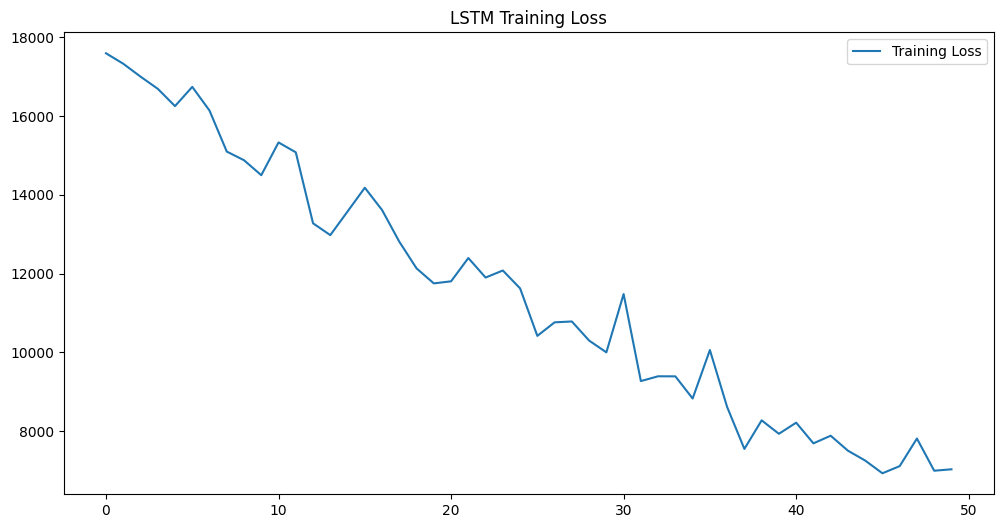

In [ ]:
# Plot Training Loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.legend()
plt.title("LSTM Training Loss")
plt.show()

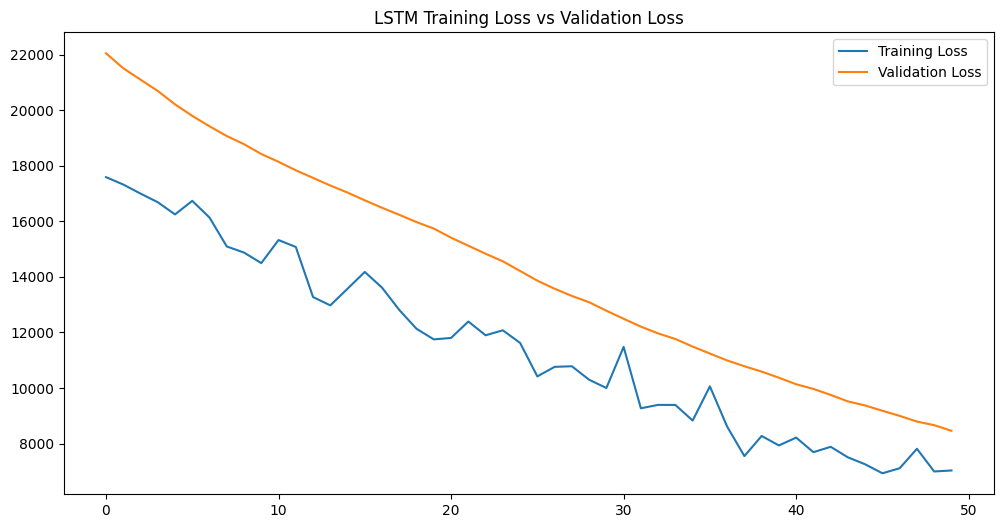

In [ ]:
# Plot Training vs Validation Loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')  # No more KeyError
plt.legend()
plt.title("LSTM Training Loss vs Validation Loss")
plt.show()

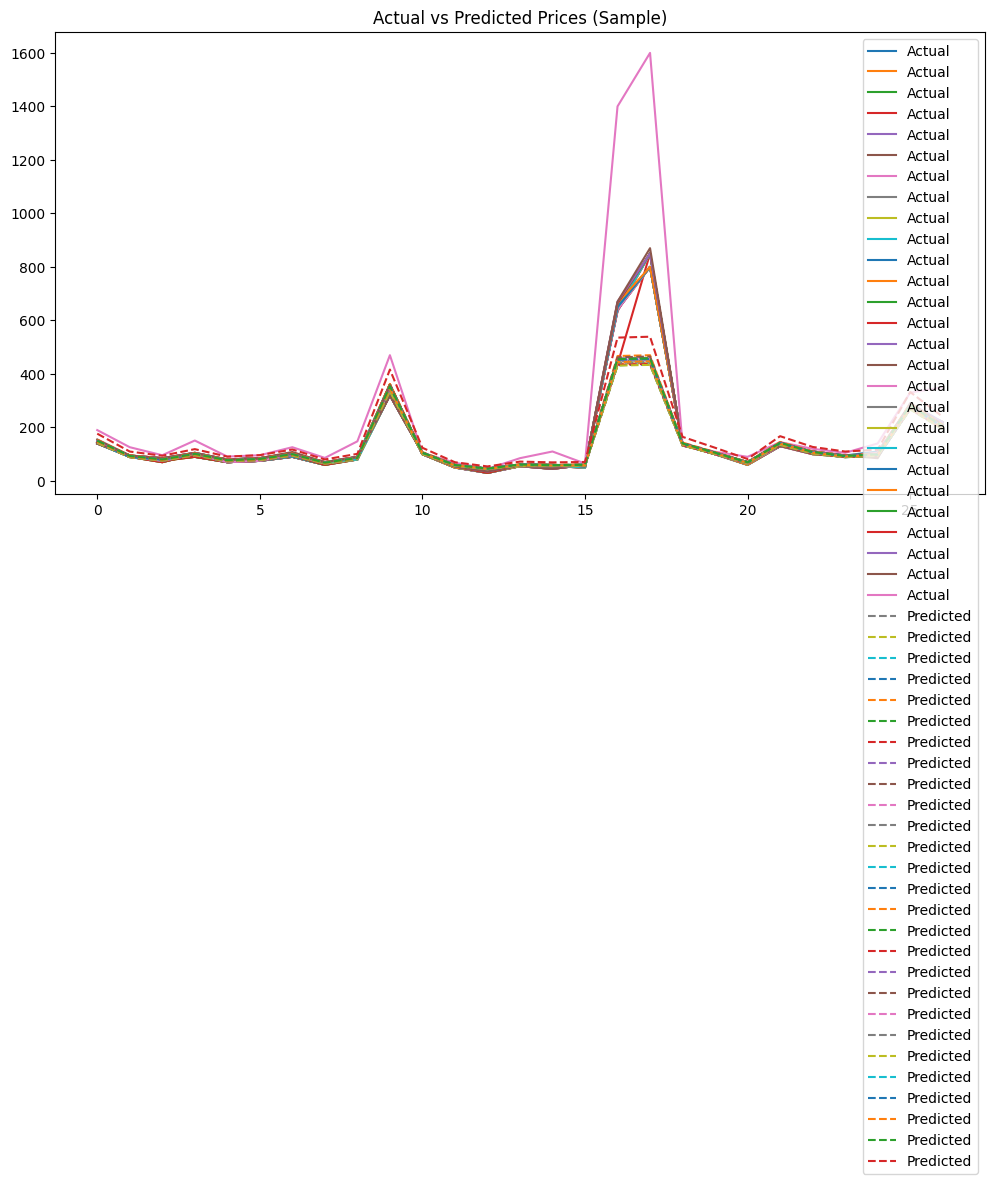

In [ ]:
# Plot Actual vs Predicted
plt.figure(figsize=(12, 6))
plt.plot(y_test[:50], label="Actual")
plt.plot(y_pred[:50], label="Predicted", linestyle="dashed")
plt.legend()
plt.title("Actual vs Predicted Prices (Sample)")
plt.show()

In [ ]:
# Define Accuracy Metric (1 - MAPE)
def accuracy(y_true, y_pred):
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return 100 - mape  # Convert error to accuracy percentage

# Calculate Accuracy
model_accuracy = accuracy(y_test, y_pred)
print(f"Model Accuracy: {model_accuracy:.2f}%")

Model Accuracy: 46.88%


In [ ]:
# Save Model
model.save("lstm_price_prediction.h5")

print("\nLSTM Model Training Complete! Model saved as 'lstm_price_prediction.h5'")


LSTM Model Training Complete! Model saved as 'lstm_price_prediction.h5'
